<div style="border:1px solid black; padding:10px; background-color: #F8F8F8;">
    <strong> <b>Notions et fonctions</b></strong><br>.
    <i> 
    <ul>
       <li> geopanda *</li>
        <li> Carte thématique</li>
        <li>  *</li>
    </ul>
    <strong> Comme d'habitude certaines cellules sont dépendantes de cellules précédentes. Il faut donc les éxécuter en suivant leur ordre dans la page</strong> 
</div>



<b>révisions</b>
<ul>
    <li> </li>
    
</ul>

# Représentation cartographique de variables qualitatives

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

Lorsqu'une variable qualitative a une dimension spatiale la représentation graphique la plus adéquate est la carte.<br>
Si la dimension spatiale et cartographique est centrale dans un projet de recherhes il est mieux d'utiliser les outils conçus pour cela, c'est à dire les systèmes d'information géographique, et à l'heure où j'écris Qgis, qui permet (plus ou moins) des sorties dans des formats non propriétaires. La maîtrise de logiciels de ce type cependant implique un apprentissage qui est long et qui n'est pas toujours aisé. <br>
Si vos besoins sont ponctuels il est tout à fait possible de réaliser des représentations cartographiques simples en utilisant Python, et plus particulièrement la bibliothèque Geopandas, souvent dans le cadre d'un environnement qui intègre également les bibliothèques permettant de visualiser et de travailler les données (c'est à dire a minima pandas). 

Nous utilisons pour l'exemple les mêmes donées que pour le carnet précédent soit le tableau décrivant les prisonniers de Bicêtre dont vous trouverez la description dans la page précédente. </br>
Première étape donc placer les données dans un dataframe et vérifiez qu'elles sont bien identifiées et ouvertes

In [3]:
chemin_fichier = 'Doc6/data2.xlsx'  
df = pd.read_excel(chemin_fichier)

# Affichage des premières lignes du DataFrame pour vérification
print(df.head())

    id        nom            prenoms   age  taille  profession  \
0  360    Barbeth          Philibert  46.0   171.0     Cordier   
1  268    Legrain      Pierre Alexis  18.0   170.0     Vannier   
2  683    Ancieux           Benjamin  18.0   168.0     Boucher   
3  751     Clouet      Paul Frédéric  17.0   155.0  Domestique   
4  933  Mettivier  François Philippe  28.0   183.0       Maçon   

     naissance_lieu naissance_departement  NumDpt domicile_commune  ...  \
0          Feillens                   Ain     1.0            Paris  ...   
1      Borlieux [?]                 Aisne     2.0            Paris  ...   
2      Capelle (La)                 Aisne     2.0            Paris  ...   
3  Ferté-Milon (La)                 Aisne     2.0            Paris  ...   
4            Epieds                 Aisne     2.0          Comegis  ...   

                                       etat_physique  \
0  Une petite cicatrice sur le pouce de la main g...   
1  Une forte cicatrice sur le dessus de 

Nous avons vu précedememnt que la repréentation graphique la plus adaptée pour certaines variables, en particulier bien sûr les lieux de naissance et de résidence sont des représentations cartographiques. <br>
Notons que ce que nous représentons en ce cas ce ne sont pas les variables elles même mais la fréquence de chacune des modalités.

Trouver un fond de carte de la France par départements n'est de nos jours pas très compliqué encore faut il qu'il soit lisible et manipulable par Geopanda

In [5]:

# Chemin vers le fichier shapefile des départements
chemin_fichier = "Doc6/departements.geojson"

# Charger les données dans un GeoDataFrame
departements_gdf = gpd.read_file(chemin_fichier)

# Afficher les 5 premières lignes du GeoDataFrame
print(departements_gdf.head())


  code                      nom  \
0   01                      Ain   
1   02                    Aisne   
2   03                   Allier   
3   04  Alpes-de-Haute-Provence   
4   05             Hautes-Alpes   

                                            geometry  
0  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2  POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...  
3  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  


In [7]:
# Convertir la colonne 'NumDpt' en chaîne, en supprimant le '.0' pour les nombres entiers
df['NumDpt'] = df['NumDpt'].apply(lambda x: str(int(x)) if x == x // 1 else str(x))

In [9]:
df_filtered = df[(df['NumDpt'] != 100) & (df['NumDpt'].notnull())]
# nous écartons les valeurs nulles et les individus nés hors de France

In [10]:
df_aggregated = df_filtered.groupby('NumDpt').size().reset_index(name='count')
# Nous comptons le nombre d'individus nés dans chaque département

In [11]:
# Convertir le code du département en str dans les deux DataFrames si nécessaire
departements_gdf['code'] = departements_gdf['code'].astype(str)
df_aggregated['NumDpt'] = df_aggregated['NumDpt'].astype(str)

# Fusionner
merged_gdf = departements_gdf.merge(df_aggregated, left_on='code', right_on='NumDpt', how='left')

# nous créeons un nouveau dataframe qui contient cette donnée et les données fournies par le fond de carte qui sont nécessaires

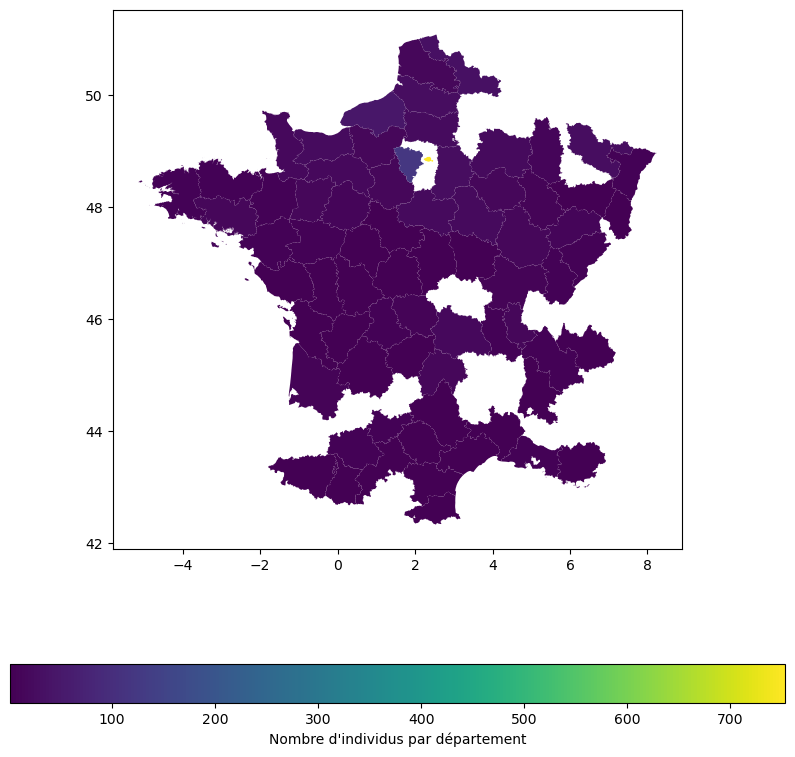

In [12]:
import matplotlib.pyplot as plt

# Réglage pour une belle carte
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='count', ax=ax, legend=True,
                legend_kwds={'label': "Nombre d'individus par département",
                             'orientation': "horizontal"})
plt.show()


Nous avons un évident problème. Plus exactement plusieurs. Le premier est que les départements de la Seine et de la Seine et Oise sont le départemnet de naissance de nombreux prisonniers, du coup une échelle linéaire ne fait apparaître que cette évidente suprématie et l'absence de certains départements en Aquitaine ou dans l'est de la France partiulièrement qui sont peu ou pas représentés. </br>
C'est un problème classiquement résolu par une transformation des données, passant soit par une discrétisation soit utilisant le Log, qui permet d'avoir sur la même figure des données qui ne sont pas de même ordre de grandeur. <br>
Ci dessous le produit d'une transformation log.

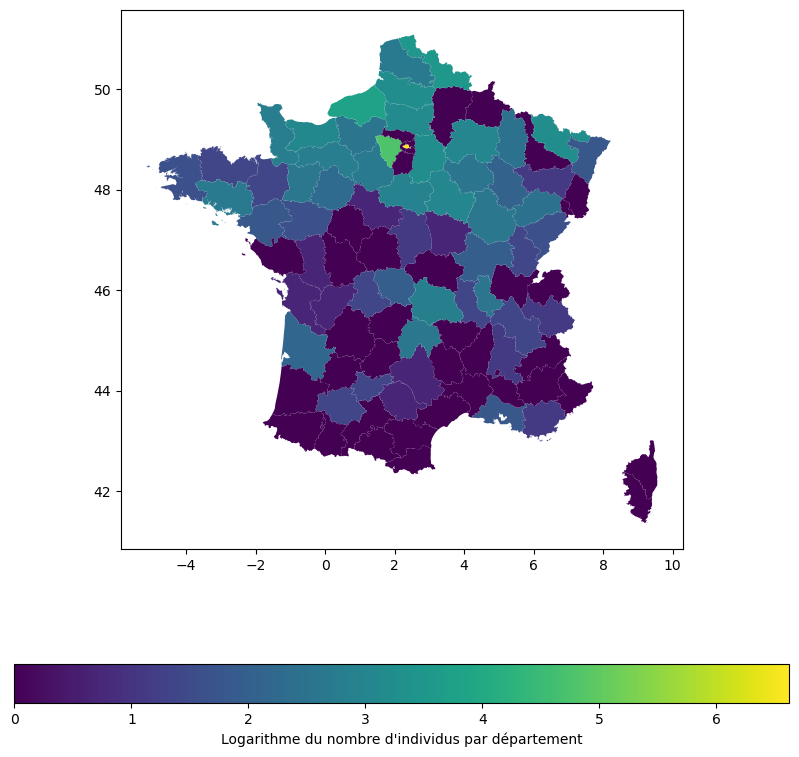

In [13]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Remplacer les valeurs 0 par une petite valeur (pour permettre la transformation logarithmique)
merged_gdf['count_log'] = merged_gdf['count'].replace(0, np.nan)
min_nonzero = merged_gdf['count_log'][merged_gdf['count_log'] > 0].min()
merged_gdf['count_log'] = merged_gdf['count_log'].fillna(min_nonzero)

# Appliquer la transformation logarithmique
merged_gdf['count_log'] = np.log(merged_gdf['count_log'])

# Dessiner la carte avec l'échelle de couleur logarithmique
merged_gdf.plot(column='count_log', ax=ax, legend=True,
                legend_kwds={'label': "Logarithme du nombre d'individus par département",
                             'orientation': "horizontal"})
plt.show()


Il apparait que, les prisons de Bicètre recrutent alors préférentielllement en Ile de France, mais que cette aire se prolonge, par dela même le bassin parisien vers les campagnes normandes et le nord de la France. La présence de deux départements auvergnants, singularité pour la France du sud de la Loire corrspond à la présence d'une importantte population migrante, employée souvent dans la construction, en provenance d'Auvergne, dont le réprésentant littéraire le plus célèbre est Gavorche, gamin de Paris qui porte une veste auvergnante. </br>
La question propre à l'historien sera de déterminer si le recrutement de Bicêtre correspond peu ou prou à celui de l'agglomération parisienne, sinon de ses résidents, du moins de la popualtion qui la traverse, ce qui supposera une mise en regard d'autres données. <br>
Le jeu de données construit par l'historien ne se comprend et ne s'étudie jamais sans référence à d'autres données historiques et à l'historiographie. 

L'autre problème loin d'être trivial pour les historines est celui du fond de carte à utliser. S'il est aisé de trouver des fichiers décrivant les réalités géograpiques contemporaines, il est bien plus difficile de trouver des fonds de carte adaptés à des données historiques. <br>
La France n'a pas les mêmes contours aujourd'hui que durant le premier XIXe siècle. Les contours de certains département ont changé, en partiuclier celui des départements, la Seine et la Seine et Oise ayant disparu du fait de la réfome de 1964. </br>
Notre carte, parlante certes et utilisable dans le cadre d'une exploration de données est cependant parfaitement fausse et impropre à la publication. 